In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from scipy.special import erfc                         # Error function, to get integral of Gaussian
from scipy.stats import norm           # Functions from SciPy Stats...
r = np.random

In [2]:
sys.path.append('../AppStat2023/External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   

In [3]:
blind = False

In [4]:
def Chauvenet(data): #Chauvenet med 5% kriterium
    n = 1
    data_subset = data
    while n>0:
        n_bef = len(data_subset)
        mask = (len(data_subset) * erfc(abs(data_subset - data_subset.mean()) / data_subset.std(ddof=1))) >= .05
        data_subset = data_subset[mask]
        n = n_bef - len(data_subset)
        print(n)
    return data_subset, len(data)-len(data_subset)

In [5]:
def constant(x,c):
    return c

def weighfit(fit, x, y, sy):
    Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)
    
    chi2fit = Chi2Regression(fit, x, y, sy)
    
    minuit_chi2 = Minuit(chi2fit, c=0)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad();          # This is where the minimisation is carried out! Put ";" at the end to void output
    return minuit_chi2

In [6]:
def weighted_mean(y_data, y_err):
    mean = weighfit(constant,  # fit function
               np.arange(len(y_data)), # arbitrary x_values
               y_data, # y-data
               y_err # y-error
              )
    for name in mean.parameters:
        value, error = mean.values[name], mean.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")
    w_mean = mean.values['c']
    w_err  = mean.errors['c'], 
    chi2_value = mean.fval
    Ndof_value = len(y_data)-1 # data-points - 1 parameter
    prob = stats.chi2.sf(chi2_value, Ndof_value)
    return w_mean, w_err, chi2_value, prob

In [7]:
# Vi er 'lige blinde' på alle målinger af samme gate, men ikke på hver gate... Skal de alle forskydes lige meget i stedet måske?
# Vi er ikke blinde på '0'

if blind:
    blinding = np.ones(5)*r.normal(0,5) # r.normal(0, 5, size=5) 
else:
    blinding = np.zeros(5)

#positioner af målere
person1_pos = np.array([19.25, 35.48, 53.45, 69.95, 87.75]) + blinding #cm
person1_pos += -person1_pos[0] # Sætter den første som 0 punkt
person1_pos_sigma = np.array([0.1]) #np.array([0.05]) #cm

person2_pos = np.array([17, 33.6, 51.4, 67.7, 85.6]) + blinding #cm
person2_pos += -person2_pos[0]
person2_pos_sigma = np.array([0.1]) #cm

person3_pos = np.array([12.10, 29.85, 46.35, 64.05, 80.65]) + blinding #cm
person3_pos += -person3_pos[0]
person3_pos_sigma = np.array([0.1]) #np.array([0.05]) #cm

person4_pos = np.array([11.24, 29.00, 45.43, 63.01, 79.84]) + blinding #cm
person4_pos += -person4_pos[0]
person4_pos_sigma = np.array([0.1]) #np.array([0.02]) #cm


# Alternative weighted mean:
#weighted_sigma = 1/np.sqrt(person1_pos_sigma**(-2) + person2_pos_sigma**(-2) + person3_pos_sigma**(-2) + person4_pos_sigma**(-2))
#weighted_pos = person1_pos*person1_pos_sigma**(-2) + person2_pos*person2_pos_sigma**(-2) + person3_pos*person3_pos_sigma**(-2) + person4_pos*person4_pos_sigma**(-2)
#weighted_pos *= weighted_sigma**(2)

gate_pos = np.zeros(len(person1_pos))
gate_err = np.zeros(len(person1_pos))

for i in range(len(person1_pos)):
    mean, err, chi2, prob = weighted_mean(
        [person1_pos[i], person2_pos[i], person3_pos[i], person4_pos[i]],
        [person1_pos_sigma[0], person2_pos_sigma[0], person3_pos_sigma[0], person4_pos_sigma[0]]
                                   )
    print(prob)
    gate_pos[i]+=mean
    gate_err[i]+=err[0]

Fit value: c = 0.00000 +/- 0.05000
1.0
Fit value: c = 17.08500 +/- 0.05000
3.6397268830395596e-40
Fit value: c = 34.26000 +/- 0.05000
0.42021813476717285
Fit value: c = 51.28000 +/- 0.05000
2.5179098004044856e-29
Fit value: c = 68.56250 +/- 0.05000
0.876140062827136


In [8]:
person1_pos, person2_pos,person3_pos,person4_pos,

(array([ 0.  , 16.23, 34.2 , 50.7 , 68.5 ]),
 array([ 0. , 16.6, 34.4, 50.7, 68.6]),
 array([ 0.  , 17.75, 34.25, 51.95, 68.55]),
 array([ 0.  , 17.76, 34.19, 51.77, 68.6 ]))

In [9]:
#Implermentering af Chauvenet! - Fjerner ét datum
for i in range(1, len(person1_pos)):
    pos = np.array([person1_pos[i], person2_pos[i], person3_pos[i], person4_pos[i]])
    pos_new, n_pos = Chauvenet(pos)
    print(pos_new)

0
[16.23 16.6  17.75 17.76]
0
[34.2  34.4  34.25 34.19]
0
[50.7  50.7  51.95 51.77]
0
[68.5  68.6  68.55 68.6 ]


In [10]:
if blind:
    blinding = r.normal(0, 3, size=2)
else:
    blinding = np.zeros(2)

#trigonometri
person1_height_length = np.array([22.05, 89.9])+blinding #cm height, length
person1_hl_sigma = np.array([0.05]) #cm

person2_height_length = np.array([22.1, 90.1])+blinding #cm height, length
person2_hl_sigma = np.array([0.2]) #cm

person3_height_length = np.array([22.7, 93.1])+blinding #cm height, length
person3_hl_sigma = np.array([0.1]) #cm

person4_height_length = np.array([22.34, 89.19])+blinding #cm height, length
person4_hl_sigma = np.array([0.05]) #cm

height_length = np.zeros(len(person1_height_length))
hl_err = np.zeros(len(person1_height_length))

for i in range(len(person1_height_length)):
    mean, err, chi2, prob = weighted_mean(
        [person1_height_length[i], person2_height_length[i], person3_height_length[i], person4_height_length[i]],
        [person1_hl_sigma[0], person2_hl_sigma[0], person3_hl_sigma[0], person4_hl_sigma[0]]
                                   )
    print(prob)
    height_length[i]+=mean
    hl_err[i]+=err[0]

Fit value: c = 22.24703 +/- 0.03288
1.0427051500550735e-08
Fit value: c = 89.94432 +/- 0.03288
3.01620095210188e-265


In [11]:
for i in range(0, len(person4_height_length)):
    pos = np.array([person1_height_length[i], person2_height_length[i], person3_height_length[i], person4_height_length[i]])
    pos_new, n_pos = Chauvenet(pos)
    print(pos_new)


0
[22.05 22.1  22.7  22.34]
0
[89.9  90.1  93.1  89.19]


In [12]:
if blind:
    blinding = np.ones(2)*r.normal(0,3, size=1) # Begge målinger forskydes med samme værdi
else:
    blinding = np.zeros(2)

# vinkel
person1_angle = np.array([13.1, 11.9]) + blinding #degrees - lille måleapperat, stort måleapperat
person1_angle_sigma = np.array([0.5]) #degrees

person2_angle = np.array([11, 13.5]) + blinding #degrees
person2_angle_sigma = np.array([0.5]) #degrees

person3_angle = np.array([14.5, 12.0]) + blinding #degrees
person3_angle_sigma = np.array([0.5]) #degrees

person4_angle = np.array([13.31, 13.34]) + blinding #degrees
person4_angle_sigma = np.array([0.05]) #degrees



angle = np.zeros(1)
angle_err = np.zeros(1)
for i in range(1):
    mean, err, chi2, prob = weighted_mean(
        [*person1_angle, *person2_angle, *person3_angle, *person4_angle],
        [person1_angle_sigma[0], person1_angle_sigma[0], person2_angle_sigma[0], person2_angle_sigma[0], person3_angle_sigma[0], person3_angle_sigma[0], person4_angle_sigma[0], person4_angle_sigma[0]]
    )
    print(chi2, prob)
    angle[i]+=mean
    angle_err[i]+=err[0]

Fit value: c = 13.30583 +/- 0.03484
42.4920388349515 4.1801501325495014e-07


In [13]:
angle_samlet = np.concatenate((person1_angle, person2_angle, person3_angle, person4_angle))
angle_ch, n_angle = Chauvenet(angle_samlet)
if n_angle:
    print(str(n_angle) + ' datapoints were removed')

0


In [14]:
if blind:
    blinding = np.ones(2)*r.normal(0,3, size=1)
else:
    blinding = np.zeros(2)
    
#vinkel efter vending - biased

person1_angle_turn = np.array([13.7, 14.2]) + blinding #degrees - lille måleapperat, stort måleapperat
person1_angle_turn_sigma = np.array([0.5]) #degrees


person2_angle_turn = np.array([14.0, 14.5]) + blinding #degrees
person2_angle_turn_sigma = np.array([0.5]) #degrees


person3_angle_turn = np.array([14.5, 14.0]) + blinding #degrees
person3_angle_turn_sigma = np.array([0.5]) #degrees

person4_angle_turn = np.array([12.9, 14.7]) + blinding #degrees
person4_angle_turn_sigma = np.array([0.05]) #degrees

angle_turn = np.zeros(1)
angle_turn_err = np.zeros(1)
for i in range(1):
    mean, err, chi2, prob = weighted_mean(
        [*person1_angle_turn, *person2_angle_turn, *person3_angle_turn, *person4_angle_turn],
        [person1_angle_turn_sigma[0], person1_angle_turn_sigma[0], person2_angle_turn_sigma[0], person2_angle_turn_sigma[0], person3_angle_turn_sigma[0], person3_angle_turn_sigma[0], person4_angle_turn_sigma[0], person4_angle_turn_sigma[0]]
    )
    print(prob)
    angle_turn[i]+=mean
    angle_turn_err[i]+=err[0]

Fit value: c = 13.81019 +/- 0.03484
1.0115865752184828e-136


In [15]:
angle_turn_samlet = np.concatenate((person1_angle_turn, person2_angle_turn, person3_angle_turn, person3_angle_turn)) 
angle_turn_ch, n_angle_turn = Chauvenet(angle_turn_samlet)
if n_angle_turn:
    print(str(n_angle_turn) + ' datapoints were removed')

0


In [16]:
if blind:
    blinding = r.normal(0,.05, size=1)
else:
    blinding = np.zeros(1)

#skinne afstand
person1_rail = np.array([0.6]) + blinding #cm
person1_rail_sigma = np.array([0.005]) #cm

person2_rail = np.array([0.6]) + blinding #cm
person2_rail_sigma = np.array([0.01]) #cm

person3_rail = np.array([0.65]) + blinding #cm
person3_rail_sigma = np.array([0.01]) #cm

person4_rail = np.array([0.57, 0.58, 0.59]) + blinding #cm
person4_rail_sigma = np.array([0.01]) #cm

rail = np.zeros(len(person1_rail))
rail_err = np.zeros(len(person1_rail))
for i in range(len(person1_rail)):
    mean, err, chi2, prob = weighted_mean(
        [person1_rail[i], person2_rail[i], person3_rail[i], person4_rail[i]],
        [person1_rail_sigma[0], person2_rail_sigma[0], person3_rail_sigma[0], person4_rail_sigma[0]]
                                   )
    print(prob)
    rail[i]+=mean
    rail_err[i]+=err[0]


Fit value: c = 0.60286 +/- 0.00378
2.615352621171109e-07


In [17]:
rail_samlet = np.concatenate((person1_rail, person2_rail, person3_rail, person4_rail))
rail_ch, n_rail = Chauvenet(rail_samlet) #fjerner ét datum
if n_rail:
    print(str(n_rail) + ' datapoints were removed')

0


In [18]:
if blind:
    blinding = r.normal(0, 1)
else:
    blinding = np.zeros(1)

#Diameter kugle
person1_diam = np.array([14.91, 14.98, 14.97]) + blinding #mm
person1_diam_sigma = np.array([0.005]) #mm

person2_diam = np.array([15, 15.02, 15.02]) + blinding #mm
person2_diam_sigma = np.array([0.002]) #mm

person3_diam = np.array([14.96, 14.96, 14.98]) + blinding #mm
person3_diam_sigma = np.array([0.02]) #mm

person4_diam = np.array([14.92, 14.941, 14.878]) + blinding #mm
person4_diam_sigma = np.array([0.005]) #mm

diam = np.zeros(1)
diam_err = np.zeros(1)
for i in range(len(person1_rail)):
    mean, err, chi2, prob = weighted_mean(
        [*person1_diam, *person2_diam, *person3_diam, *person4_diam],
        [person1_diam_sigma[0], person1_diam_sigma[0], person1_diam_sigma[0], #Vi har 3 målinger med samme usikkerhed
         person2_diam_sigma[0], person2_diam_sigma[0], person2_diam_sigma[0],
         person3_diam_sigma[0], person3_diam_sigma[0], person3_diam_sigma[0],
         person4_diam_sigma[0], person4_diam_sigma[0], person4_diam_sigma[0]]
                                   )
    print(prob)
    diam[i]+=mean
    diam_err[i]+=err[0]

Fit value: c = 14.99369 +/- 0.00100
0.0


In [19]:
diam_samlet = np.concatenate((person1_diam, person2_diam, person3_diam, person4_diam))
diam_ch, n_diam = Chauvenet(diam_samlet) #fjerner tre datapunkter
if n_diam:
    print(str(n_diam) + ' datapoints were removed')

0


In [20]:
# Værdier vi har
gate_pos, gate_err;          # Beliggenhed af gates +- sigma
height_length, hl_err;       # Højde & Længde af bane +- sigma på hver
angle, angle_err;            # Vinkel + bord +- sigma
angle_turn, angle_turn_err;  # Vinkel + bord efter vending +- sigma
rail, rail_err;              # Sliskebredde +- sigma
diam, diam_err;              # Bolddiameter +- sigma


In [21]:
datnames = ['Incline_dat', 'Incline_datrot'] # The data for 'normal' table and rotated
datnum = [16, 5] # How many of each dataset we have
dattroels = 'Incline_Troels1.csv'

#getting each dataset:
dataset = 0 #Either dataset unrotated or rotated (0 or 1)
data = []
data_rot = []

for i in range(datnum[0]):
    file = 'dat/'+datnames[0]+str(i)+'.csv'
    dat = np.genfromtxt(file, delimiter=',', skip_header=1)
    time, voltage = dat[:,0], dat[:,1]
    mask = (time<1)*(time>-0.2)
    data += [[time[mask],voltage[mask]]] # Now data[i][0] is all the time data and [i][1] is the voltage

for i in range(datnum[1]):
    file = 'dat/'+datnames[1]+str(i)+'.csv'
    dat = np.genfromtxt(file, delimiter=',', skip_header=1)
    time, voltage = dat[:,0], dat[:,1]
    mask = (time<1)*(time>-0.2)
    data_rot += [[time[mask],voltage[mask]]] # Now data[i][0] is all the time data and [i][1] is the voltage
# I checked all datasets, all 'passes' happened way before 1 second and after -0.2, so I've removed those

In [22]:
if blind:
    blinding = r.uniform(0,0.01, size=5)
else:
    blinding = np.zeros(5)

timepoints = np.zeros((datnum[0], 5))
for i in range(datnum[0]):
    passnum = 0
    for j in range(len(data[i][1])-1):
        if (data[i][1][j]<4.5)*(data[i][1][j+1]>4.5):
            timepoints[i,passnum]+=data[0][0][j] + blinding[passnum]
            #plt.plot([timepoints[i,passnum],timepoints[i,passnum]], [0,5], '--') # PLOTTING TO SHOW
            passnum+=1
plt.show()
timepoints_rot = np.zeros((datnum[1], 5))
for i in range(datnum[1]):
    passnum = 0
    for j in range(len(data_rot[i][1])-1):
        if (data_rot[i][1][j]<4.5)*(data_rot[i][1][j+1]>4.5):
            timepoints_rot[i,passnum]+=data_rot[0][0][j] + blinding[passnum]
            #plt.plot([timepoints[i,passnum],timepoints[i,passnum]], [0,5], '--')  # PLOTTING TO SHOW
            passnum+=1
print(np.shape(timepoints))
print(np.shape(timepoints_rot))

(16, 5)
(5, 5)


chi2 = 87.10528111538729, ndof = 2, p = 1.2171063645914042e-19
144.12660078753393 53.947833726089996 -0.019085303074464655


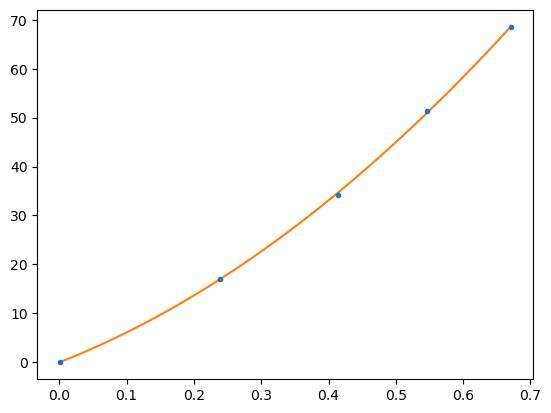

In [23]:
# fit of a single experiment
# Something bad happended to the chi2
# review gate_err, might wanna consider moving away from own estimate of errors

plt.errorbar(timepoints[1], gate_pos, yerr=gate_err, fmt='.')
def fit_func(t, a, v0, s0):
    return 1/2 * a * t**2 + v0 * t + s0

def fit(fit, x, y, sy):
    Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)
    chi2fit = Chi2Regression(fit, x, y, sy)
    minuit_chi2 = Minuit(chi2fit, a=1, v0=0.5, s0=0)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad();          # This is where the minimisation is carried out! Put ";" at the end to void output
    return minuit_chi2

fit_result = fit(fit_func, timepoints[1], gate_pos, gate_err)
ndof = len(timepoints[1]) - 3
prob = stats.chi2.sf(fit_result.fval, ndof)

print(f"chi2 = {fit_result.fval}, ndof = {ndof}, p = {prob}")
x = np.linspace(timepoints[1][0], timepoints[1][-1], 100)
plt.plot(x, fit_func(x, *fit_result.values))
print(*fit_result.values)


In [24]:
if blind:
    blinding = np.ones(5)*r.normal(0,5) # r.normal(0, 5, size=5) 
else:
    blinding = np.zeros(5)

person1_pos = np.array([19.25, 35.48, 53.45, 69.95, 87.75]) + blinding #cm
person2_pos = np.array([17, 33.6, 51.4, 67.7, 85.6]) + blinding #cm
person3_pos = np.array([12.10, 29.85, 46.35, 64.05, 80.65]) + blinding #cm
person4_pos = np.array([11.24, 29.00, 45.43, 63.01, 79.84]) + blinding #cm
pos_sigma = 1 * np.ones(5) #cm

In [25]:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)


In [26]:
def func_gaussian(x, N, mu, sigma) :
    return N * stats.norm.pdf(x, mu, sigma)
def fit_pdf(x, N, binwidth, mu, sigma) :
        """Gaussian"""
        return N * binwidth * stats.norm.pdf(x, mu, sigma)

In [27]:
def fit_gaussian(residuals):

    # parameters for histogram
    res_max = max(residuals)*2
    res_min = min(residuals)
    xmax = np.ceil(res_max)
    xmin = -np.ceil(res_max)
        
    k = np.ceil(res_max)*2    

    Nbins = 5
    binwidth = (k)/Nbins
    counts, bin_edges = np.histogram(residuals, bins=Nbins, range=(xmin, xmax))
    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

    chi2fit = Chi2Regression(fit_pdf, x, y, sy)
    minuit_chi2 = Minuit(chi2fit, N=np.sum(y), binwidth = k, mu=0, sigma=1)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

    sigma = minuit_chi2.values["sigma"]

    return sigma, minuit_chi2

fit_result = fit(fit_func, timepoints[1], person1_pos, pos_sigma)
ndof = len(timepoints[1]) - 3
prob = stats.chi2.sf(fit_result.fval, ndof)

fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
ax.errorbar(x = timepoints[1], y = person1_pos, yerr=pos_sigma, label='Person 1', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax.plot(x, fit_func(x, *fit_result.values)) 

ax.set(xlabel="Time in seconds", # the label of the y axis
       ylabel="Position in cm",  # the label of the y axis
       title="Fit of acceleration, person 1, timeset 2", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero
# Adding fit results to plot:

d = {'a [cm/s^2]':   [fit_result.values['a'], fit_result.errors['a']],
     'v [cm/s]':       [fit_result.values['v0'], fit_result.errors['v0']],
     's [cm]':       [fit_result.values['s0'], fit_result.errors['s0']],
     'Chi2':     fit_result.fval,
     'ndf':      ndof,
     'Prob':     prob,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.62, 0.95, text, ax, fontsize=20)
ax.legend(loc='lower left', fontsize=18); # could also be # loc = 'upper right' e.g.
fig.tight_layout()

residuals = fit_func(timepoints[1], *fit_result.values) - person1_pos

#"frame2 = fig_fit.add_axes((.1,.1,.8,.2))        

#plt.hist(residuals, bins = 5) 
#plt.plot(np.linspace(-0.3, 0.3, 100), gauss_pdf(np.linspace(-0.3, 0.3, 100), mu = 0, sigma = np.std(residuals)))


print(f"chi2 = {fit_result.fval}, ndof = {ndof}, p = {prob}")
print(*fit_result.values)


In [76]:
def acc_plot(pos_points, time_points, sigma_pos):
    fit_result = fit(fit_func, time_points, pos_points, sigma_pos)
    residuals = fit_func(time_points, *fit_result.values) - pos_points
    sigma_res = np.std(residuals) * np.ones(5)

    fit_result_sigma =  fit(fit_func, time_points, pos_points, sigma_res)

    ndof = len(time_points) - 3
    prob = stats.chi2.sf(fit_result_sigma.fval, ndof)

    fig = plt.figure(figsize=(16, 16))  # figsize is in inches
    frame1 = fig.add_axes((.1,.3,.8,.6))

    frame1.errorbar(x = time_points, y = pos_points, yerr=sigma_res, label='Person', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
    frame1.plot(np.linspace(time_points[0], time_points[-1], 100), fit_func(np.linspace(time_points[0], time_points[-1], 100), *fit_result_sigma.values)) 

    #frame1.set(xlabel="Time in seconds", # the label of the y axis
    #       ylabel="Position in cm",  # the label of the y axis
    #       title="Fit of acceleration", # the title of the plot
    #       ylim=[0.0,None]) # Setting the miminum to zero
    frame1.set_xlabel('Time [s]', fontsize=22)
    frame1.set_ylabel('Position [cm]', fontsize=22)
    frame1.set_title('Fit of acceleration', fontsize = 22)
    
    plt.rc('xtick',labelsize=22)
    plt.rc('ytick',labelsize=22)
    # Adding fit results to plot:

    d = {'a [cm/s^2]':   [fit_result_sigma.values['a'], fit_result_sigma.errors['a']],
         'v [cm/s]':       [fit_result_sigma.values['v0'], fit_result_sigma.errors['v0']],
         's [cm]':       [fit_result_sigma.values['s0'], fit_result_sigma.errors['s0']],
         'Chi2':     fit_result_sigma.fval,
         'ndf':      ndof,
         'Prob':     prob,
        }

    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.95, text, frame1, fontsize=20)
    frame1.legend(loc='lower left', fontsize=18); # could also be # loc = 'upper right' e.g.
    fig.tight_layout()
    
    frame2 = fig.add_axes((.62,.35,.27,.27), )
    
    res_max = max(residuals)*2
    res_min = min(residuals)
    
    frame2.hist(residuals, bins = 5, range = (-np.ceil(res_max), np.ceil(res_max))) 
    
    k = np.ceil(res_max)*2    
    
    frame2.plot(np.linspace(-np.ceil(res_max), np.ceil(res_max), 100), func_gaussian(np.linspace(-np.ceil(res_max), np.ceil(res_max), 100), N=k, mu = 0, sigma = np.std(residuals)))
    frame2.set_xlabel('Position [cm]', fontsize=18)
    frame2.set_ylabel('Frequency', fontsize=18)

    f = {'std [cm]':   np.std(residuals),
         'mean [cm]':       0,}

    text_2 = nice_string_output(f, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.95, text_2, frame2, fontsize=16)
    frame1.legend(loc='lower left', fontsize=10); # could also be # loc = 'upper right' e.g.
    print(residuals)
    
    return fit_result_sigma, ndof, prob

C:\Users\ander\AppData\Local\Temp\ipykernel_17092\996946734.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


[-0.04560564  0.15793337 -0.12920524 -0.03660304  0.05348056]


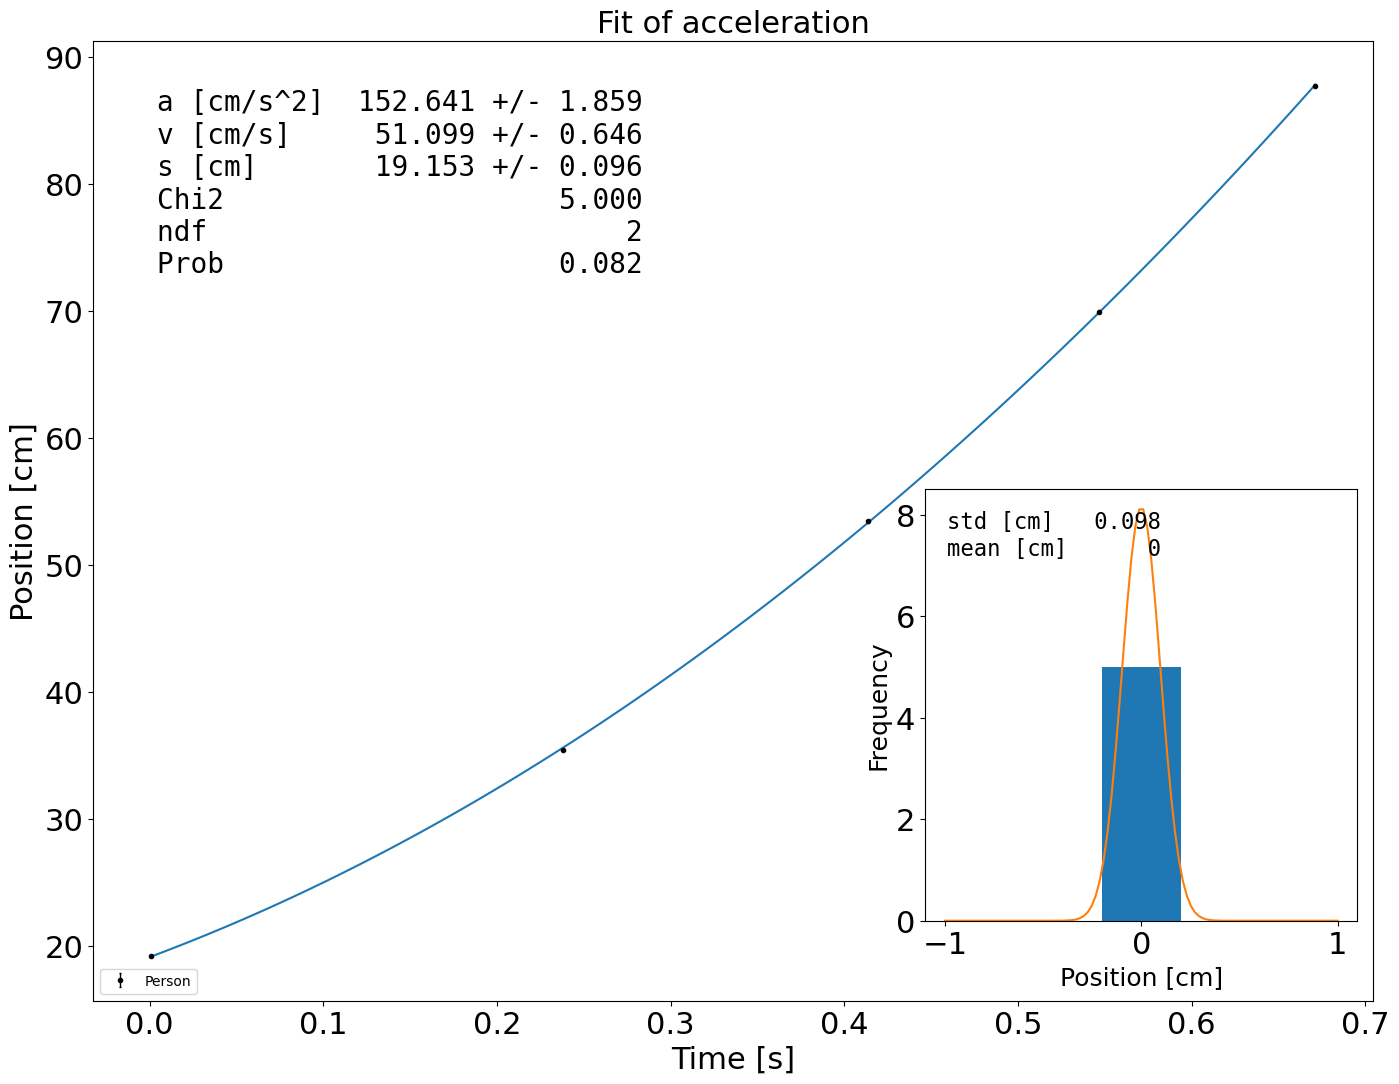

In [77]:
fit_1, ndof_1, prob_1 = acc_plot(person1_pos, timepoints[1], pos_sigma)

C:\Users\ander\AppData\Local\Temp\ipykernel_17092\3482566482.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


[-0.00012791  0.02489944 -0.09552313  0.11200479 -0.0412532 ]


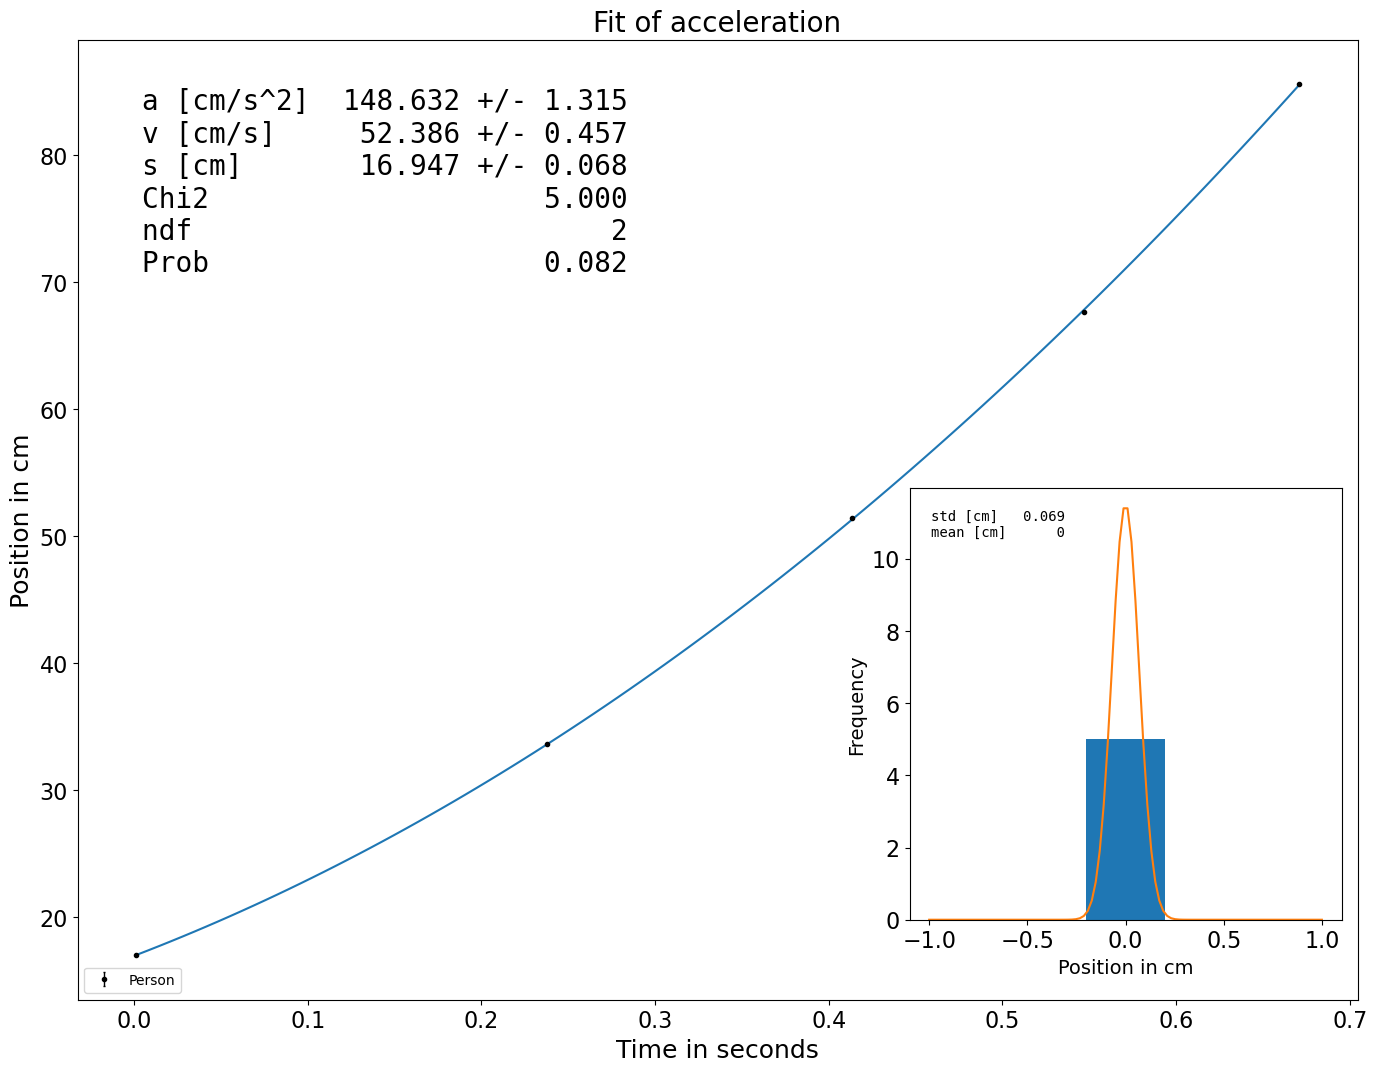

In [61]:
fit_2, ndof_2, prob_2 = acc_plot(person2_pos, timepoints[1], pos_sigma)

C:\Users\ander\AppData\Local\Temp\ipykernel_17092\1015437583.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


[ 0.0795895  -0.42220751  0.795859   -0.60807073  0.15482977]


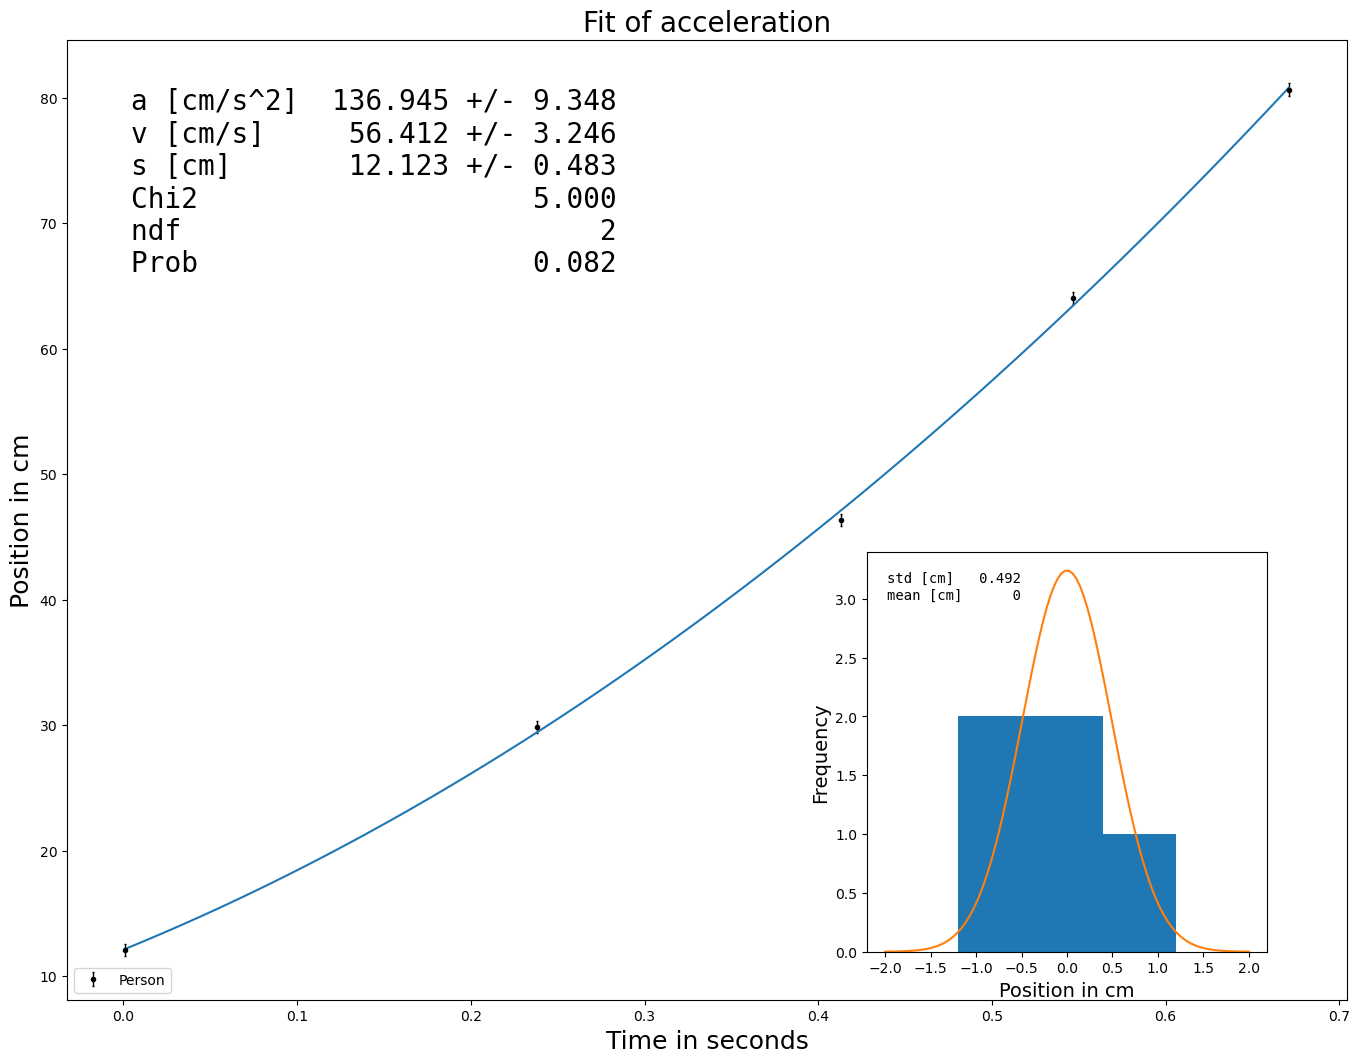

In [31]:
fit_3, ndof_3, prob_3 = acc_plot(person3_pos, timepoints[1], pos_sigma)

C:\Users\ander\AppData\Local\Temp\ipykernel_17092\1015437583.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


[ 0.10588243 -0.49081444  0.78301133 -0.4840764   0.08599708]


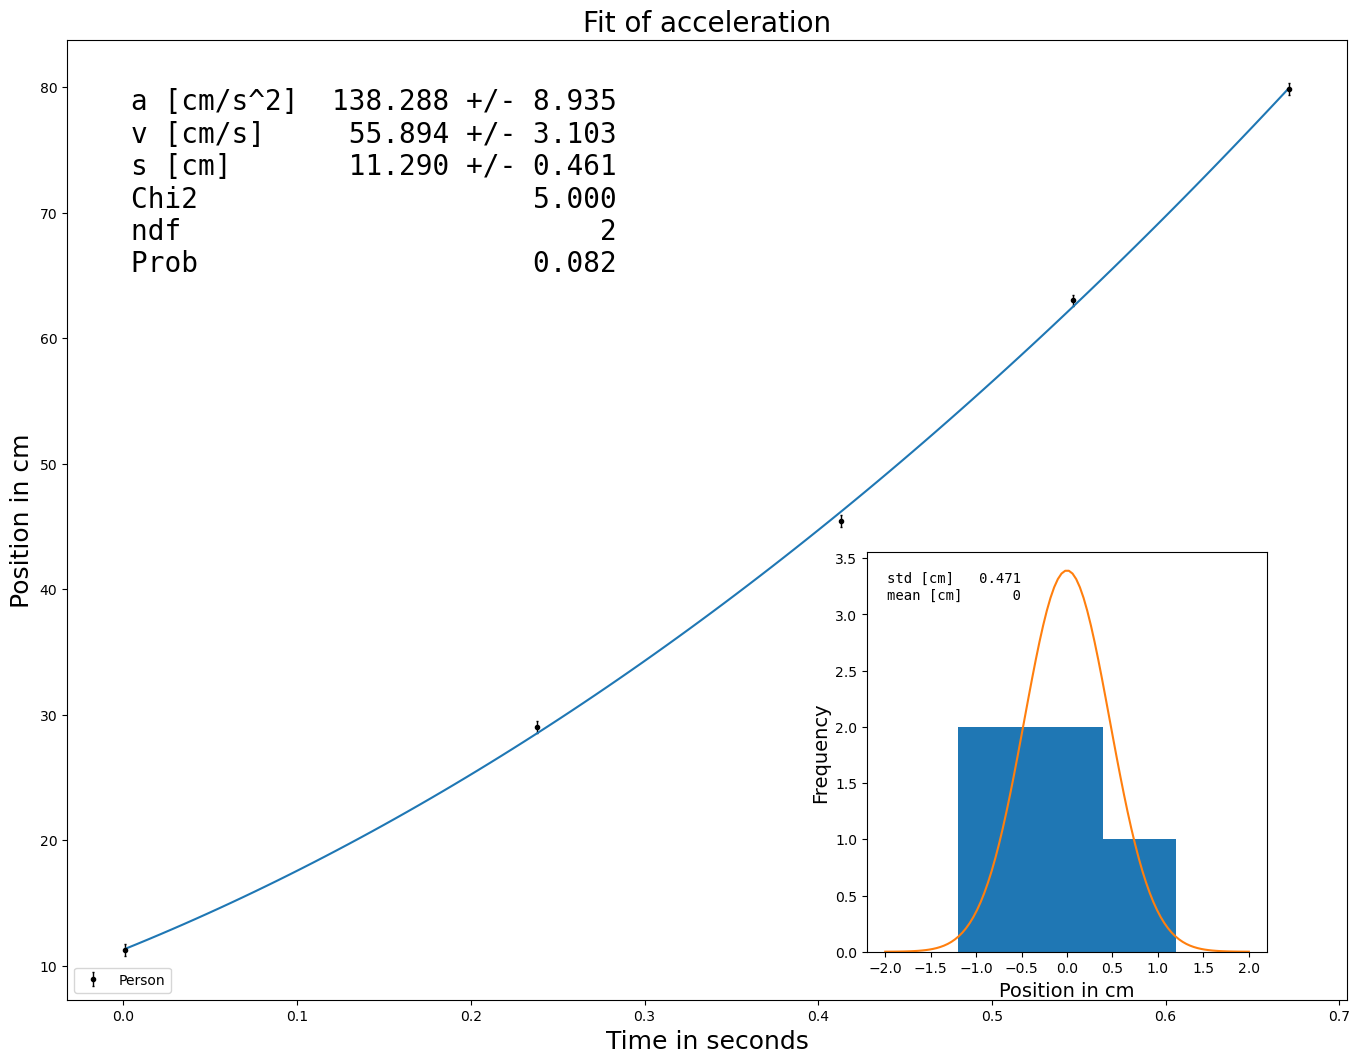

In [32]:
fit_4, ndof_4, prob_4 = acc_plot(person4_pos, timepoints[1], pos_sigma)

C:\Users\ander\AppData\Local\Temp\ipykernel_17092\1015437583.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


[-0.03613032  0.15032754 -0.12911267 -0.03914898  0.05641433]
[ 0.00115549  0.02015723 -0.09066444  0.11151523 -0.0421635 ]
[ 0.08141476 -0.42778066  0.8008937  -0.6081824   0.15365458]
[ 0.10781274 -0.4963874   0.78789241 -0.48428112  0.08496335]


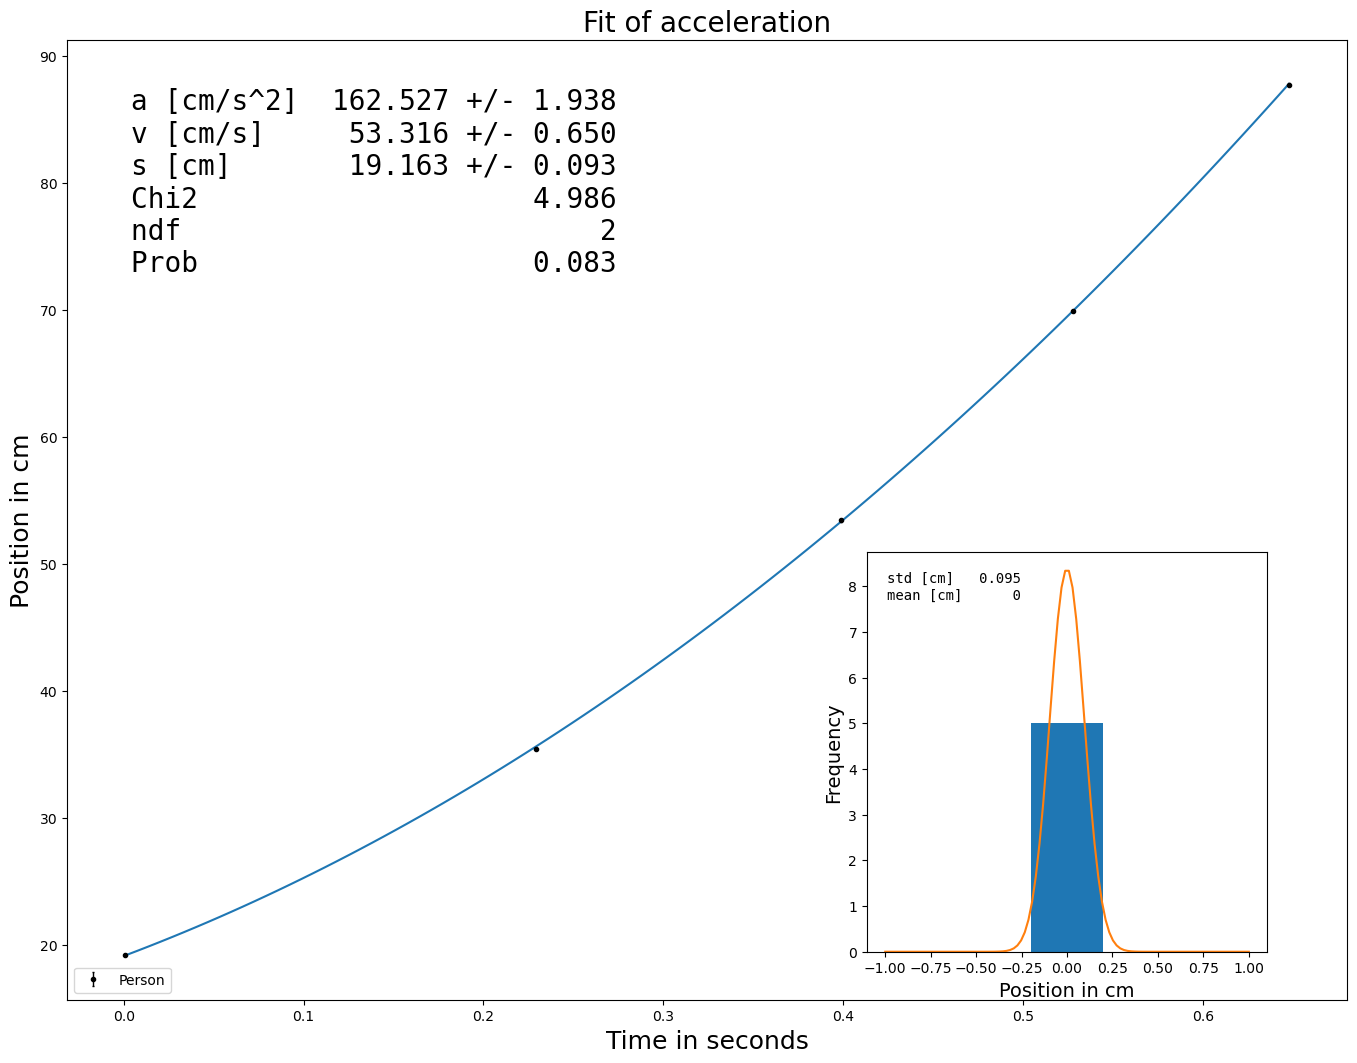

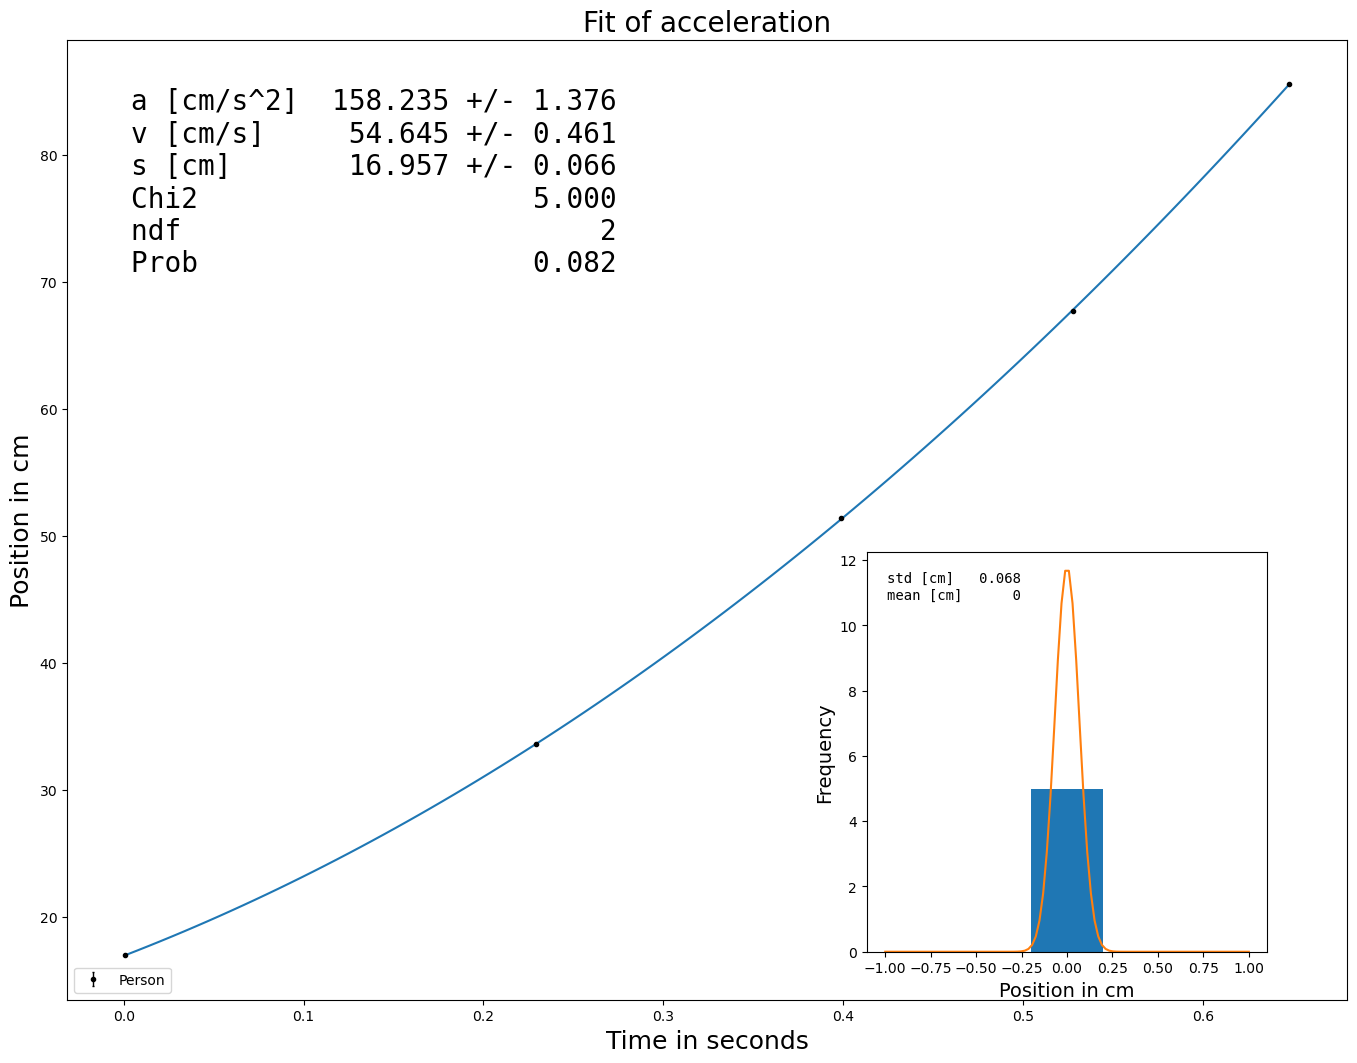

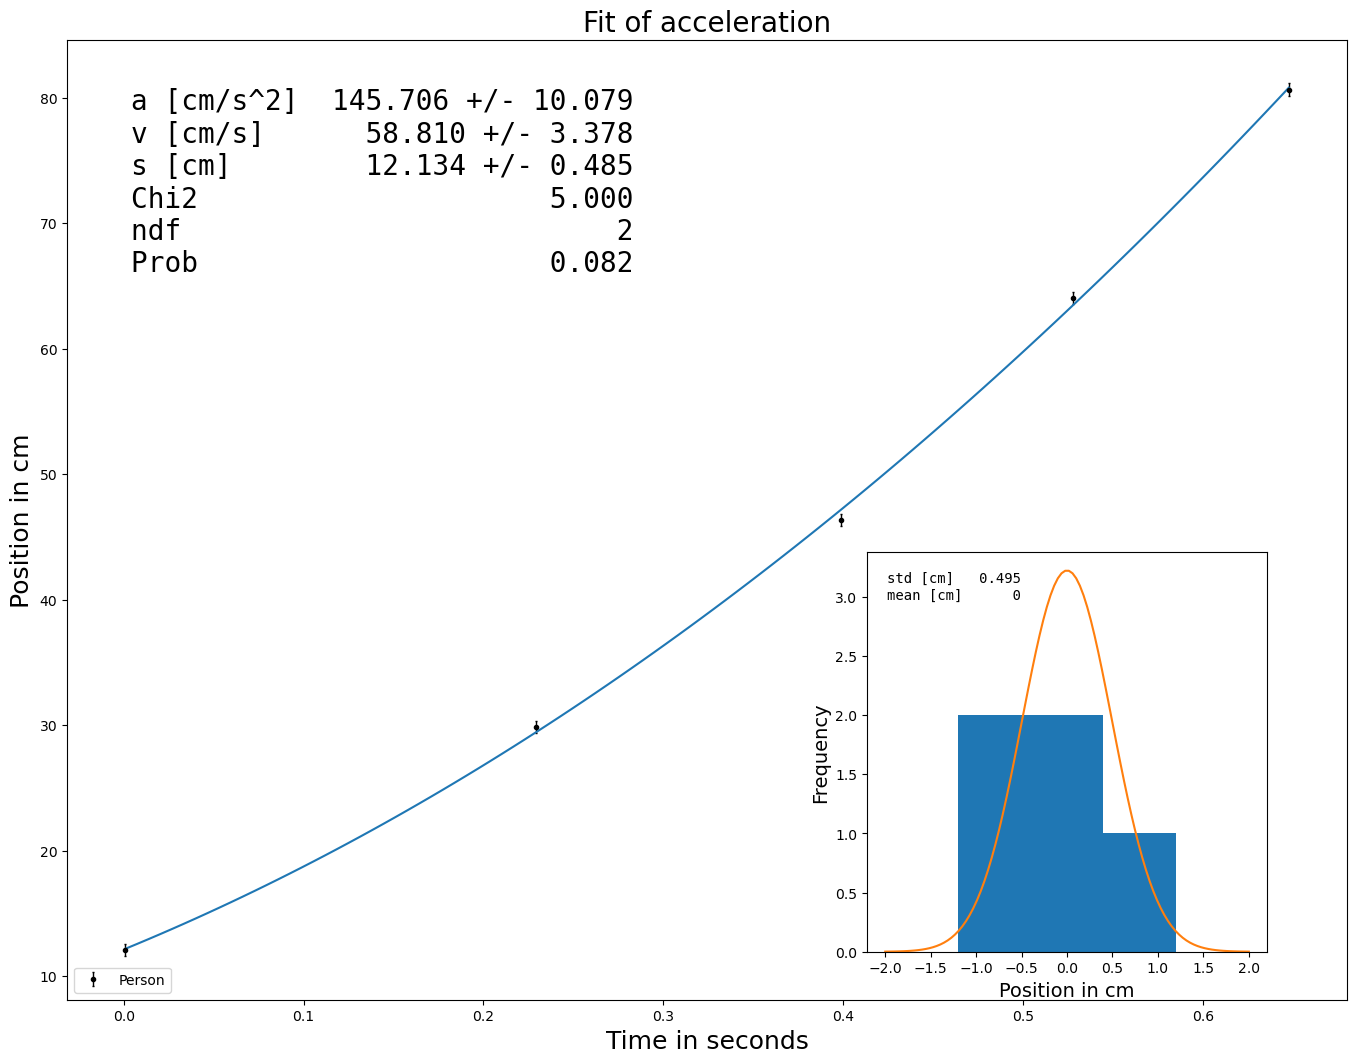

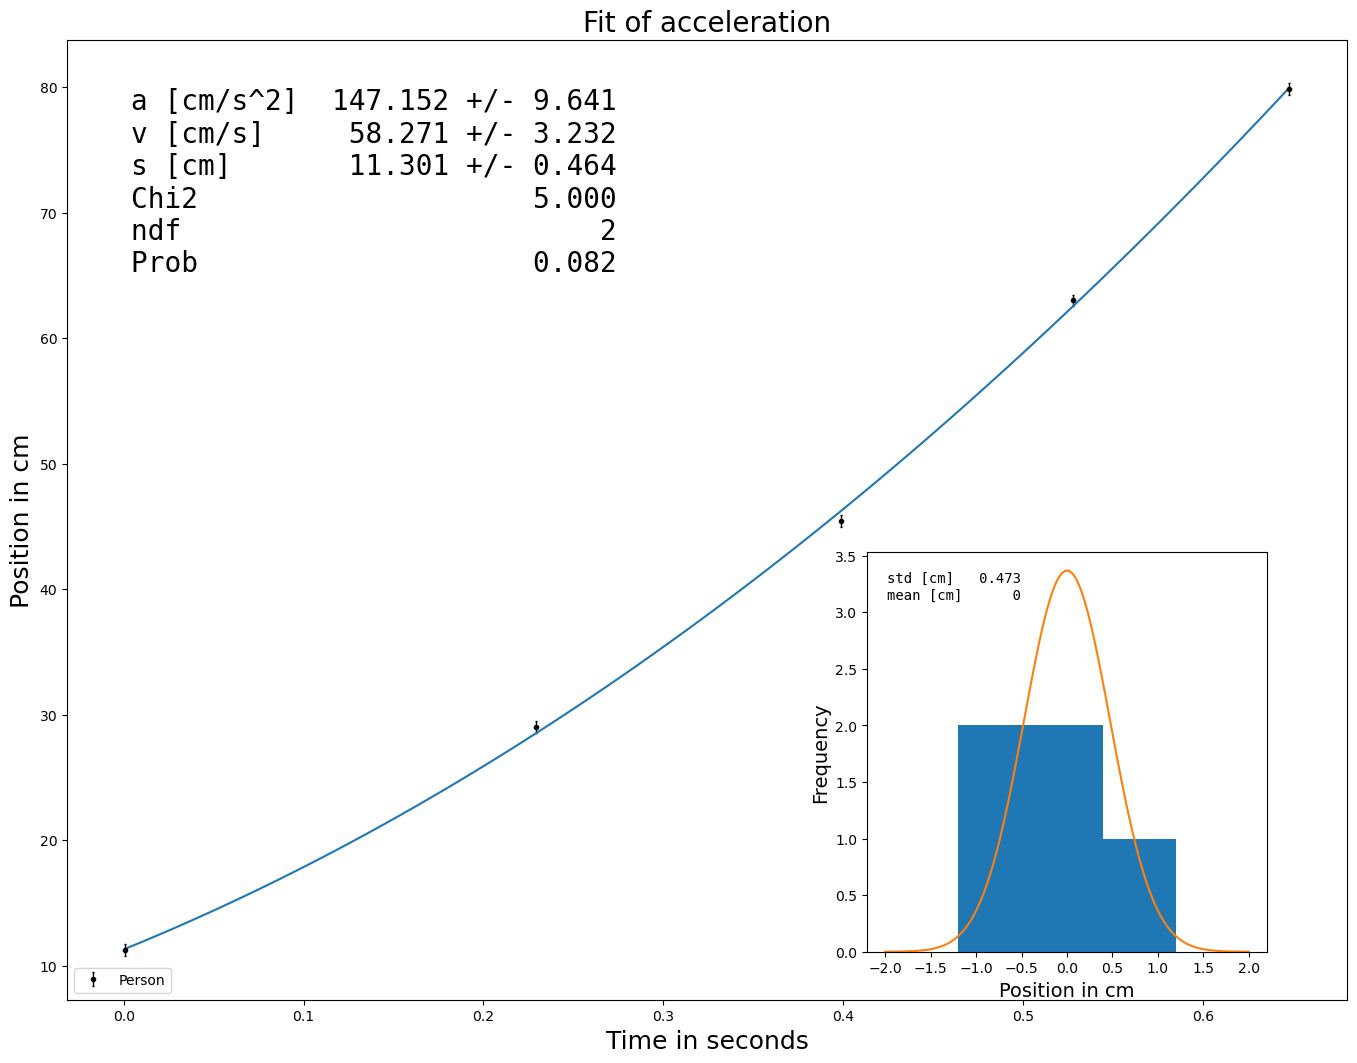

In [33]:
fit_1_rot, ndof_1_rot, prob_1_rot = acc_plot(person1_pos, timepoints_rot[0], pos_sigma)
fit_2_rot, ndof_2_rot, prob_2_rot = acc_plot(person2_pos, timepoints_rot[0], pos_sigma)
fit_3_rot, ndof_3_rot, prob_3_rot = acc_plot(person3_pos, timepoints_rot[0], pos_sigma)
fit_4_rot, ndof_4_rot, prob_4_rot = acc_plot(person4_pos, timepoints_rot[0], pos_sigma)

In [34]:
acc_fit = np.array([fit_1.values['a'], fit_2.values['a'], fit_3.values['a'], fit_4.values['a']])
acc_fit_sigma = np.array([fit_1.errors['a'], fit_2.errors['a'], fit_3.errors['a'], fit_4.errors['a']]) 
print(acc_fit)
print(acc_fit_sigma)

[152.64142612 148.63225839 136.94459095 138.28812708]
[1.85899777 1.31545381 9.34830863 8.9350483 ]


In [35]:
acc_rot_fit = np.array([fit_1_rot.values['a'], fit_2_rot.values['a'], fit_3_rot.values['a'], fit_4_rot.values['a']])
acc_rot_fit_sigma = np.array([fit_1_rot.errors['a'], fit_2_rot.errors['a'], fit_3_rot.errors['a'], fit_4_rot.errors['a']]) 
print(acc_rot_fit)
print(acc_rot_fit_sigma)

[162.52692564 158.23491608 145.70632096 147.15241102]
[ 1.93827858  1.37649686 10.07888442  9.64136317]


In [36]:
acc_mean, acc_err, acc_chi2, acc_prob = weighted_mean(acc_fit, acc_fit_sigma)
acc_rot_mean, acc_rot_err, acc_rot_chi2, acc_rot_prob = weighted_mean(acc_rot_fit, acc_rot_fit_sigma)

print(acc_chi2, acc_prob)
print(acc_rot_chi2, acc_rot_prob)

Fit value: c = 149.63851 +/- 1.05927
Fit value: c = 159.33966 +/- 1.10800
6.65203634458294 0.0838555935305628
6.775655923986236 0.07940275590403731


In [37]:
from errorPropIncline import *

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [38]:
#trigonometrisk beregning af vinklerne
theta_vals = np.array([eval_theta(person1_height_length[0], person1_height_length[1]), eval_theta(person2_height_length[0], person2_height_length[1]), eval_theta(person3_height_length[0], person3_height_length[1]), eval_theta(person4_height_length[0], person4_height_length[1])])
theta_vals_err = np.array([eval_etheta(person1_height_length[0], person1_height_length[1], 0.2, 0.2), eval_etheta(person2_height_length[0], person2_height_length[1], 0.2, 0.2), eval_etheta(person3_height_length[0], person3_height_length[1], 0.2, 0.2), eval_etheta(person4_height_length[0], person4_height_length[1], 0.2, 0.2)])
theta_mean, theta_err, theta_chi2, theta_prob = weighted_mean(theta_vals, theta_vals_err)
print(theta_chi2, theta_prob)

Fit value: c = 0.24136 +/- 0.00107
4.905989834299443 0.1788118886997688


In [39]:
print(theta_mean*180/np.pi, theta_err[0]*180/np.pi)

13.828728362009041 0.061417407841971514


In [40]:
#direkte måling af vinklerne
theta_dir_mean, theta_dir_err = np.mean([*person1_angle, *person2_angle, *person3_angle, *person4_angle]), np.std([*person1_angle, *person2_angle, *person3_angle, *person4_angle])/np.sqrt(len([*person1_angle, *person2_angle, *person3_angle, *person4_angle]))
#direkte måling af vinklerne, roteret
theta_rot_mean, theta_rot_err = np.mean([*person1_angle_turn, *person2_angle_turn, *person3_angle_turn, *person4_angle_turn]), np.std([*person1_angle_turn, *person2_angle_turn, *person3_angle_turn, *person4_angle_turn])/np.sqrt(len([*person1_angle_turn, *person2_angle_turn, *person3_angle_turn, *person4_angle_turn]))


In [41]:
print(theta_dir_mean, theta_dir_err)
print(theta_rot_mean, theta_rot_err)
DTheta_gono = (theta_dir_mean- theta_rot_mean)/2
DTheta_gono_err = np.sqrt(theta_dir_err**2 + theta_rot_err**2)
print(DTheta_gono, DTheta_gono_err)

12.83125 0.36877939501482454
14.0625 0.1895203650007037
-0.6156249999999996 0.41462779807617817


In [42]:
DTheta_a = eval_Delta(acc_mean, acc_rot_mean, theta_mean)
DTheta_a_err = eval_eDelta(acc_mean, acc_rot_mean, theta_mean, acc_err[0], acc_rot_err[0], theta_err[0])
print(np.rad2deg(DTheta_a))
print(np.rad2deg(DTheta_a_err))

-0.44282007779179394
0.06993560853157527


In [43]:
Dtheta_mean, Dtheta_err, Dtheta_chi2, Dtheta_prob = weighted_mean([DTheta_a, np.deg2rad(DTheta_gono)], [DTheta_a_err, np.deg2rad(DTheta_gono_err)])
print(Dtheta_chi2, Dtheta_prob)
print(np.rad2deg(Dtheta_mean), "err:", np.rad2deg(Dtheta_err))

Fit value: c = -0.00781 +/- 0.00120
0.16889324129560915 0.6810972979474532
-0.44760035275346 err: [0.06896152]


In [44]:
from errorPropIncline import *

In [45]:
rail_mean = np.mean([*person1_rail, *person2_rail, *person3_rail, *person4_rail])
rail_err = np.std([*person1_rail, *person2_rail, *person3_rail, *person4_rail])/len([*person1_rail, *person2_rail, *person3_rail, *person4_rail])
diam_mean = np.mean([*person1_diam, *person2_diam, *person3_diam, *person4_diam])
diam_err = np.std([*person1_diam, *person2_diam, *person3_diam, *person4_diam])/len([*person1_diam, *person2_diam, *person3_diam, *person4_diam])
g_for_real = eval_g(acc_mean/100, diam_mean/1000, rail_mean/100, theta_mean, DTheta_a)


In [46]:
g_err = eval_eg(g_for_real, acc_mean/100, diam_mean/1000, rail_mean/100, theta_mean, DTheta_a, acc_err[0]/100, diam_err/1000, rail_err/100, theta_err[0], DTheta_a_err)

g_err_a = eval_ega(g_for_real, acc_mean/100, diam_mean/1000, rail_mean/100, theta_mean, DTheta_a, acc_err[0]/100, diam_err/1000, rail_err/100, theta_err[0], DTheta_a_err)
g_err_D = eval_egD(g_for_real, acc_mean/100, diam_mean/1000, rail_mean/100, theta_mean, DTheta_a, acc_err[0]/100, diam_err/1000, rail_err/100, theta_err[0], DTheta_a_err)
g_err_d = eval_egd(g_for_real, acc_mean/100, diam_mean/1000, rail_mean/100, theta_mean, DTheta_a, acc_err[0]/100, diam_err/1000, rail_err/100, theta_err[0], DTheta_a_err)
g_err_theta = eval_egtheta(g_for_real, acc_mean/100, diam_mean/1000, rail_mean/100, theta_mean, DTheta_a, acc_err[0]/100, diam_err/1000, rail_err/100, theta_err[0], DTheta_a_err)
g_err_Delta = eval_egDelta(g_for_real, acc_mean/100, diam_mean/1000, rail_mean/100, theta_mean, DTheta_a, acc_err[0]/100, diam_err/1000, rail_err/100, theta_err[0], DTheta_a_err)


In [47]:
print(g_for_real, g_err)
print("Err. contributio from acc.;", abs(g_err_a))
print("Err. contributio from Diameter;", abs(g_err_D))
print("Err. contributio from rail;", abs(g_err_d))
print("Err. contributio from theta;", abs(g_err_theta))
print("Err. contributio from Delta-theta;", abs(g_err_Delta))


9.541286970798618 0.09419655507629332
Err. contributio from acc.; 0.06754134047338121
Err. contributio from Diameter; 0.0002720957684164269
Err. contributio from rail; 0.008304227622107228
Err. contributio from theta; 0.042978061251189394
Err. contributio from Delta-theta; 0.048938842792632616


In [48]:
print(acc_mean/100, "err:", acc_err[0]/100)
print(diam_mean/1000, "err:", diam_err/1000)
print(rail_mean/100, "err:", rail_err/100)
print(np.rad2deg(theta_mean), "err:", np.rad2deg(theta_err))
print(np.rad2deg(DTheta_a), "err:", np.rad2deg(DTheta_a_err))
print((DTheta_gono), "err:", (DTheta_gono_err))


1.496385061122779 err: 0.010592685578150624
0.014961583333333332 err: 3.4740203677341946e-06
0.005983333333333333 err: 4.240093756242712e-05
13.828728362009041 err: [0.06141741]
-0.44282007779179394 err: 0.06993560853157527
-0.6156249999999996 err: 0.41462779807617817
